# Part B



In [ ]:
# Setting the seed here is sufficient. 
# If you don't plan to use these starter code, make sure you add this cell.

SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers, metrics
from tensorflow.keras.metrics import RootMeanSquaredError, MeanSquaredError
from tensorflow.keras.layers import Normalization, StringLookup, IntegerLookup, Embedding, Reshape, Flatten
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
df = pd.read_csv('/content/hdb_price_prediction.csv')


In [ ]:
# The functions in this cell are adapted from https://keras.io/examples/structured_data/structured_data_classification_from_scratch/
# It is the same link as the one mentioned in the question paper (Q1b)

def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


In [ ]:
from keras import backend as K

def r2(y_true, y_pred): 
    '''
    # Obtained from https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
    # TODO: you have to find out how to use it in your code
    '''
    SS_res = K.sum(K.square( y_true - y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Q1a) 

The validation data should be a good representative of the problem we are trying to solve. In the case of HDB prices, a trend is observerved where the prices are rising, in a broad based manner (irrespective of HDB type), and the pace of increase of prices is slowing down as well. Due to this, we have chosen our Test split from year 2021 onwards, such that it represents the trend, and is more representative of our problem.

Furthermore, with the broad-based manner of rising prices, we will have room for further evaluation as to whether the rising prices are a result of some attributes of the HDB flats.

In [ ]:
# Split data
train_dataframe = df[df['year'] <= 2020]
test_dataframe = df[df['year'] > 2020]

# Generate tf.data.Dataset objects for each dataframe
train_ds = dataframe_to_dataset(train_dataframe)
test_ds = dataframe_to_dataset(test_dataframe)

# Batch the datasets
train_ds = train_ds.batch(256)
test_ds = test_ds.batch(256)

# Q1b) Encode + Standardise + concatenate data, build NN architecture

In [ ]:
# Categorical features (integers)
month = keras.Input(shape=(1,), name="month", dtype="int64")

# Categorical features encoded (integers)
month_encoded = encode_categorical_feature(month, "month", train_ds, False)

# Categorical feature (String)
flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")

# Categorical feature encoded (String)
flat_model_type_encoded = encode_categorical_feature(flat_model_type, "flat_model_type", train_ds, True)
storey_range_encoded = encode_categorical_feature(storey_range, "storey_range", train_ds, True)


# Numerical features
dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")

# Numerical Features Encoded
dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)
degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)
remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)

# Combining all inputs
all_inputs = [
    month,
    flat_model_type,
    storey_range,
    dist_to_nearest_stn,
    dist_to_dhoby,
    degree_centrality,
    eigenvector_centrality,
    remaining_lease_years,
    floor_area_sqm
]

# Combining all Encoded inputs
all_features = layers.concatenate(
    [
        month_encoded,
        flat_model_type_encoded,
        storey_range_encoded,
        dist_to_nearest_stn_encoded,
        dist_to_dhoby_encoded,
        degree_centrality_encoded,
        eigenvector_centrality_encoded,
        remaining_lease_years_encoded,
        floor_area_sqm_encoded,
    ]
)

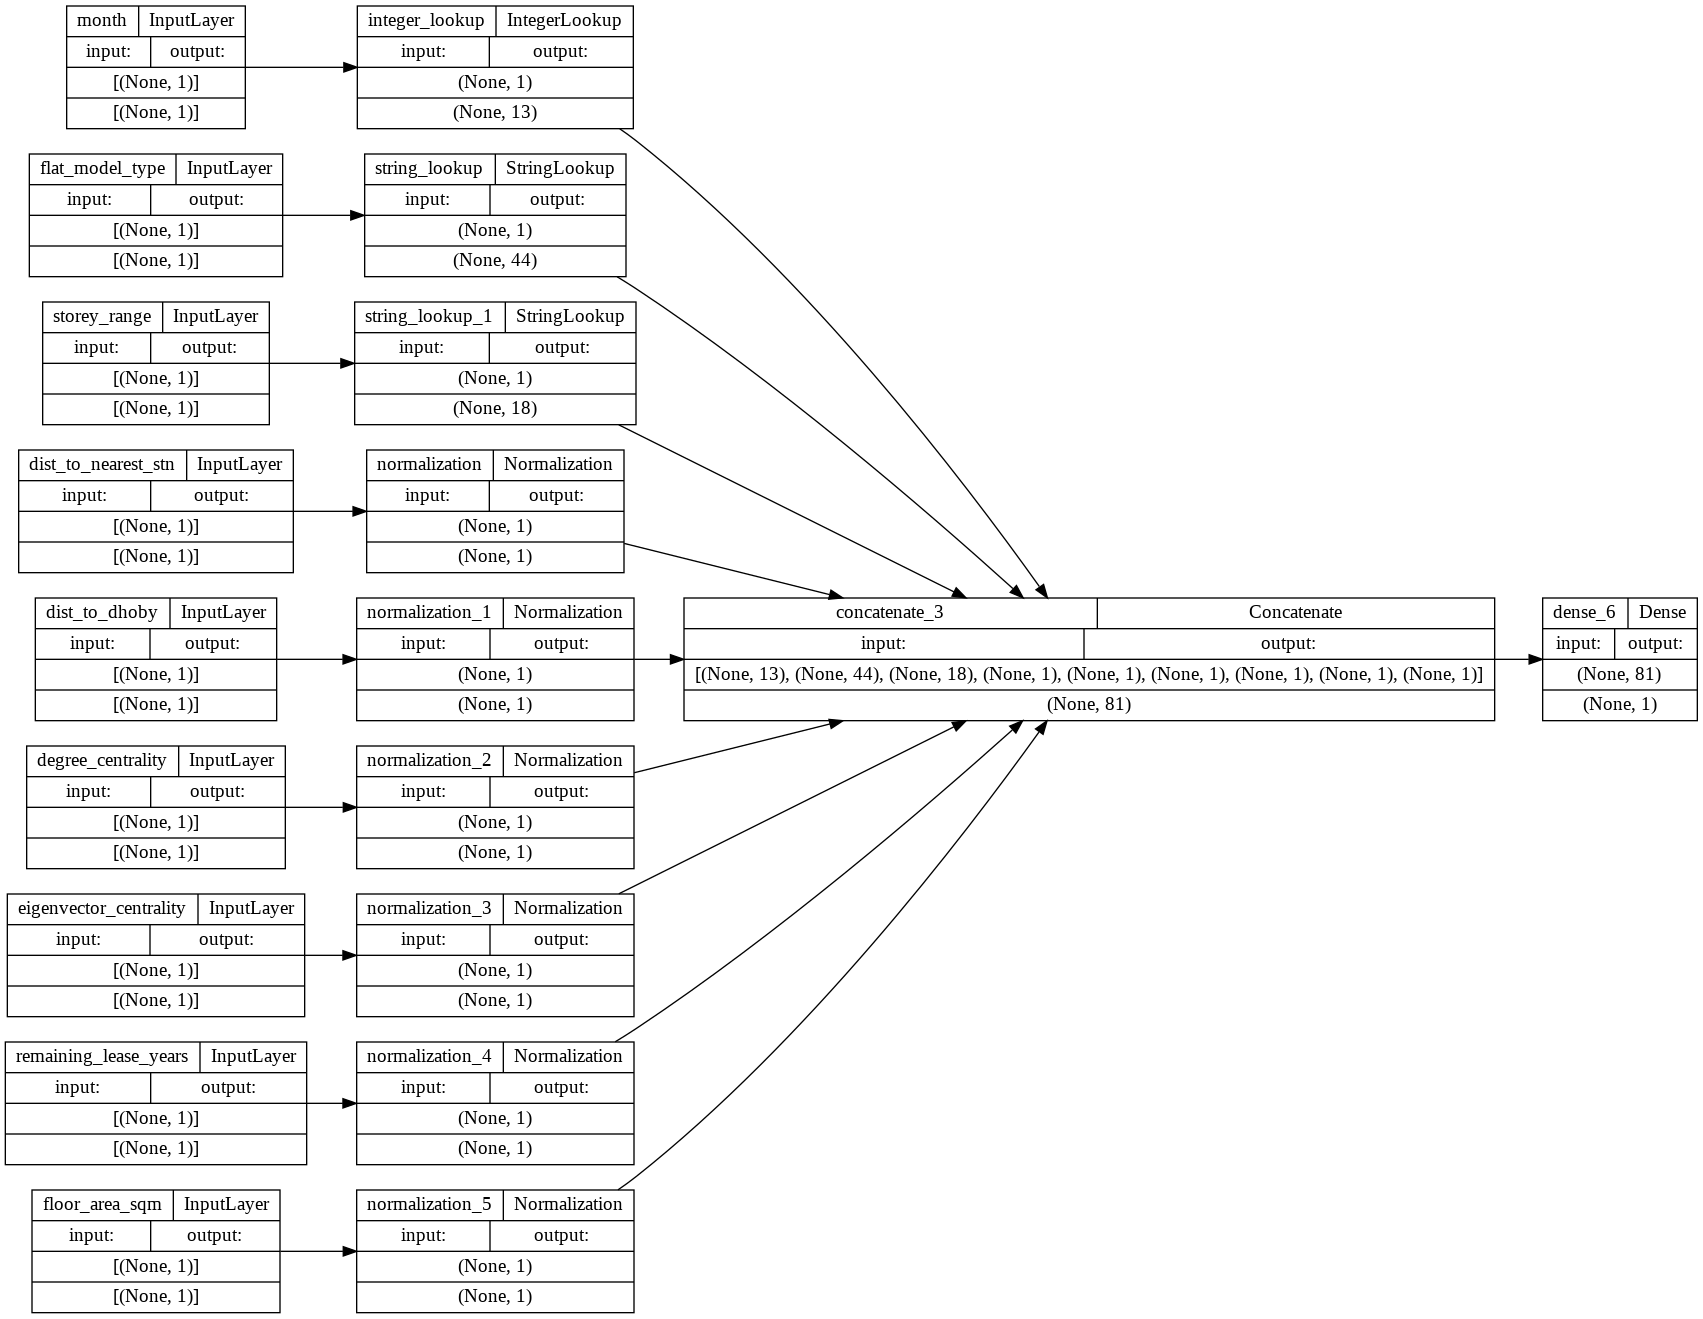

In [ ]:
output = layers.Dense(1, activation="linear")(all_features)
model = keras.Model(all_inputs, output)
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR" )

# Q1c)

Compile model with **adam** optimizer and fit. After training the model and evaluating the model against the test dataset, we can see the R2 value = -10.2092

In [ ]:
output = layers.Dense(1, activation="linear")(all_features)
model = keras.Model(all_inputs, output)

opt_adam = keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt_adam,loss='mse',metrics=[r2])

model.fit(train_ds, epochs=50,batch_size=256)

Epoch 1/50
683/683 [==============================] - 3s 3ms/step - loss: 219585347584.0000 - r2: -8.4708
Epoch 2/50
683/683 [==============================] - 3s 3ms/step - loss: 219582840832.0000 - r2: -8.4813
Epoch 3/50
683/683 [==============================] - 2s 3ms/step - loss: 219580071936.0000 - r2: -8.4724
Epoch 4/50
683/683 [==============================] - 2s 3ms/step - loss: 219577630720.0000 - r2: -8.4859
Epoch 5/50
683/683 [==============================] - 3s 3ms/step - loss: 219574960128.0000 - r2: -8.4749
Epoch 6/50
683/683 [==============================] - 2s 3ms/step - loss: 219572322304.0000 - r2: -8.4669
Epoch 7/50
683/683 [==============================] - 3s 3ms/step - loss: 219569815552.0000 - r2: -8.4583
Epoch 8/50
683/683 [==============================] - 2s 3ms/step - loss: 219567390720.0000 - r2: -8.4635
Epoch 9/50
683/683 [==============================] - 5s 7ms/step - loss: 219564654592.0000 - r2: -8.4771
Epoch 10/50
683/683 [=========================

In [ ]:
model.evaluate(test_ds)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


360/360 [==============================] - 2s 3ms/step - loss: 301335740416.0000 - r2: -10.2092


[301335740416.0, -10.209212303161621]

Compile model with SGD optimizer and fit. From below when we evaluate the model on the test dataset, we can see that the test r2 value for SGD optimizer is approximately 0.6151, which is much better than the adam optimizer

In [ ]:
output = layers.Dense(1, activation="linear")(all_features)
model = keras.Model(all_inputs, output)

opt_SGD = keras.optimizers.SGD(learning_rate=0.01)

model.compile(optimizer=opt_SGD,loss='mse',metrics=[r2])

model.fit(train_ds, epochs=50,batch_size=256)

Epoch 1/50
683/683 [==============================] - 3s 3ms/step - loss: 12144516096.0000 - r2: 0.4925
Epoch 2/50
683/683 [==============================] - 2s 2ms/step - loss: 4900073984.0000 - r2: 0.7909
Epoch 3/50
683/683 [==============================] - 2s 3ms/step - loss: 4546454016.0000 - r2: 0.8058
Epoch 4/50
683/683 [==============================] - 2s 3ms/step - loss: 4348314112.0000 - r2: 0.8142
Epoch 5/50
683/683 [==============================] - 3s 3ms/step - loss: 4217671424.0000 - r2: 0.8197
Epoch 6/50
683/683 [==============================] - 2s 3ms/step - loss: 4127392512.0000 - r2: 0.8239
Epoch 7/50
683/683 [==============================] - 3s 3ms/step - loss: 4060579072.0000 - r2: 0.8262
Epoch 8/50
683/683 [==============================] - 3s 3ms/step - loss: 4010072320.0000 - r2: 0.8283
Epoch 9/50
683/683 [==============================] - 2s 3ms/step - loss: 3971471872.0000 - r2: 0.8296
Epoch 10/50
683/683 [==============================] - 2s 3ms/step - los

In [ ]:
model.evaluate(test_ds)

360/360 [==============================] - 1s 3ms/step - loss: 10406544384.0000 - r2: 0.6151


[10406544384.0, 0.6150740385055542]

# Q1d)

Add dense layer with 10 neurons and compile with adam(lr=0.08) instead. From below after evaluating the model, we can see that the test r2 is approximately 0.6150

In [ ]:
x = layers.Dense(10, activation="linear")(all_features)
output = layers.Dense(1, activation="relu")(x)
model = keras.Model(all_inputs, output)

opt_adam = keras.optimizers.Adam(learning_rate=0.08)

model.compile(optimizer=opt_adam,loss='mse',metrics=[r2])

model.fit(train_ds, epochs=50,batch_size=256)

Epoch 1/50
683/683 [==============================] - 6s 6ms/step - loss: 150435495936.0000 - r2: -5.4681 - val_loss: 92124332032.0000 - val_r2: -2.4270
Epoch 2/50
683/683 [==============================] - 6s 8ms/step - loss: 15845826560.0000 - r2: 0.3214 - val_loss: 14587541504.0000 - val_r2: 0.4639
Epoch 3/50
683/683 [==============================] - 6s 8ms/step - loss: 5220807680.0000 - r2: 0.7773 - val_loss: 12317461504.0000 - val_r2: 0.5474
Epoch 4/50
683/683 [==============================] - 6s 8ms/step - loss: 4645909504.0000 - r2: 0.8019 - val_loss: 11848505344.0000 - val_r2: 0.5639
Epoch 5/50
683/683 [==============================] - 6s 8ms/step - loss: 4292919040.0000 - r2: 0.8167 - val_loss: 11281532928.0000 - val_r2: 0.5842
Epoch 6/50
683/683 [==============================] - 5s 7ms/step - loss: 4074821120.0000 - r2: 0.8259 - val_loss: 11149740032.0000 - val_r2: 0.5893
Epoch 7/50
683/683 [==============================] - 5s 7ms/step - loss: 3940972800.0000 - r2: 0.831

In [ ]:
model.evaluate(test_ds)

360/360 [==============================] - 1s 3ms/step - loss: 10406554624.0000 - r2: 0.6150


[10406554624.0, 0.6149933934211731]

# Q1e)

Among the 3 models, we can see that the NN architecture in 1d) performed the best with the highest R2 score of 0.62. This is because it has a deeper network. The additional Dense layer allows for the model to better learn the multiple features in the training data. Hence, giving better results.

# Q2a)Split dataset 

In [ ]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="int") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature

In [ ]:
# Split data
train_dataframe = df[df['year'] < 2020]
val_dataframe = df[df['year'] == 2020]
test_dataframe = df[df['year'] > 2020]

# Generate tf.data.Dataset objects for each dataframe
train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)
test_ds = dataframe_to_dataset(test_dataframe)

# Batch the datasets
train_ds = train_ds.batch(256)
val_ds = val_ds.batch(256)
test_ds = test_ds.batch(256)


# Q2b) Use Embedding layer for categorical data instead of one-hot encoding

In [ ]:
# Categorical features (integers)
month = keras.Input(shape=(1,), name="month", dtype="int64")

# Categorical features encoded (integers)
month_encoded = encode_categorical_feature(month, "month", train_ds, False)

# Categorical feature (String)
flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")

# Categorical feature encoded (String)
flat_model_type_encoded = encode_categorical_feature(flat_model_type, "flat_model_type", train_ds, True)
storey_range_encoded = encode_categorical_feature(storey_range, "storey_range", train_ds, True)

# Numerical features
dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")

# Numerical Features Encoded
dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)
degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)
remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)

# Combining all inputs
all_inputs = [
    month,
    flat_model_type,
    storey_range,
    dist_to_nearest_stn,
    dist_to_dhoby,
    degree_centrality,
    eigenvector_centrality,
    remaining_lease_years,
    floor_area_sqm
]

In [ ]:
embedding_layers = []

# All Categorial Variables to be embedded
categorial_variables = ["month", "flat_model_type", "storey_range"]

# All Categorial Variables (encoded)
categorial_variables_encoded = [month_encoded, flat_model_type_encoded, storey_range_encoded]

# Generate an embedding for each categorial variable and store it
for categorial_variable, categorial_variable_encoded in zip(categorial_variables, categorial_variables_encoded):

    # Output dimensions
    unique_categories  = train_dataframe[categorial_variable].nunique()
    embedding_size = np.floor((unique_categories)/2)
    embedding_size = int(embedding_size)

    # Input Dimensions
    input_dim  = unique_categories + 1
    
    # Embedding Layer
    embedding = Embedding(input_dim = input_dim, output_dim = embedding_size)(categorial_variable_encoded)


    # Add Flatten() layer
    embedding = Flatten()(embedding)
    embedding_layers.append(embedding)

In [ ]:
# Combining all Encoded inputs
all_features = layers.concatenate(
    [
        embedding_layers[0],
        embedding_layers[1],
        embedding_layers[2],
        dist_to_nearest_stn_encoded,
        dist_to_dhoby_encoded,
        degree_centrality_encoded,
        eigenvector_centrality_encoded,
        remaining_lease_years_encoded,
        floor_area_sqm_encoded,
    ]
)

NN architecture built from the embedding layers

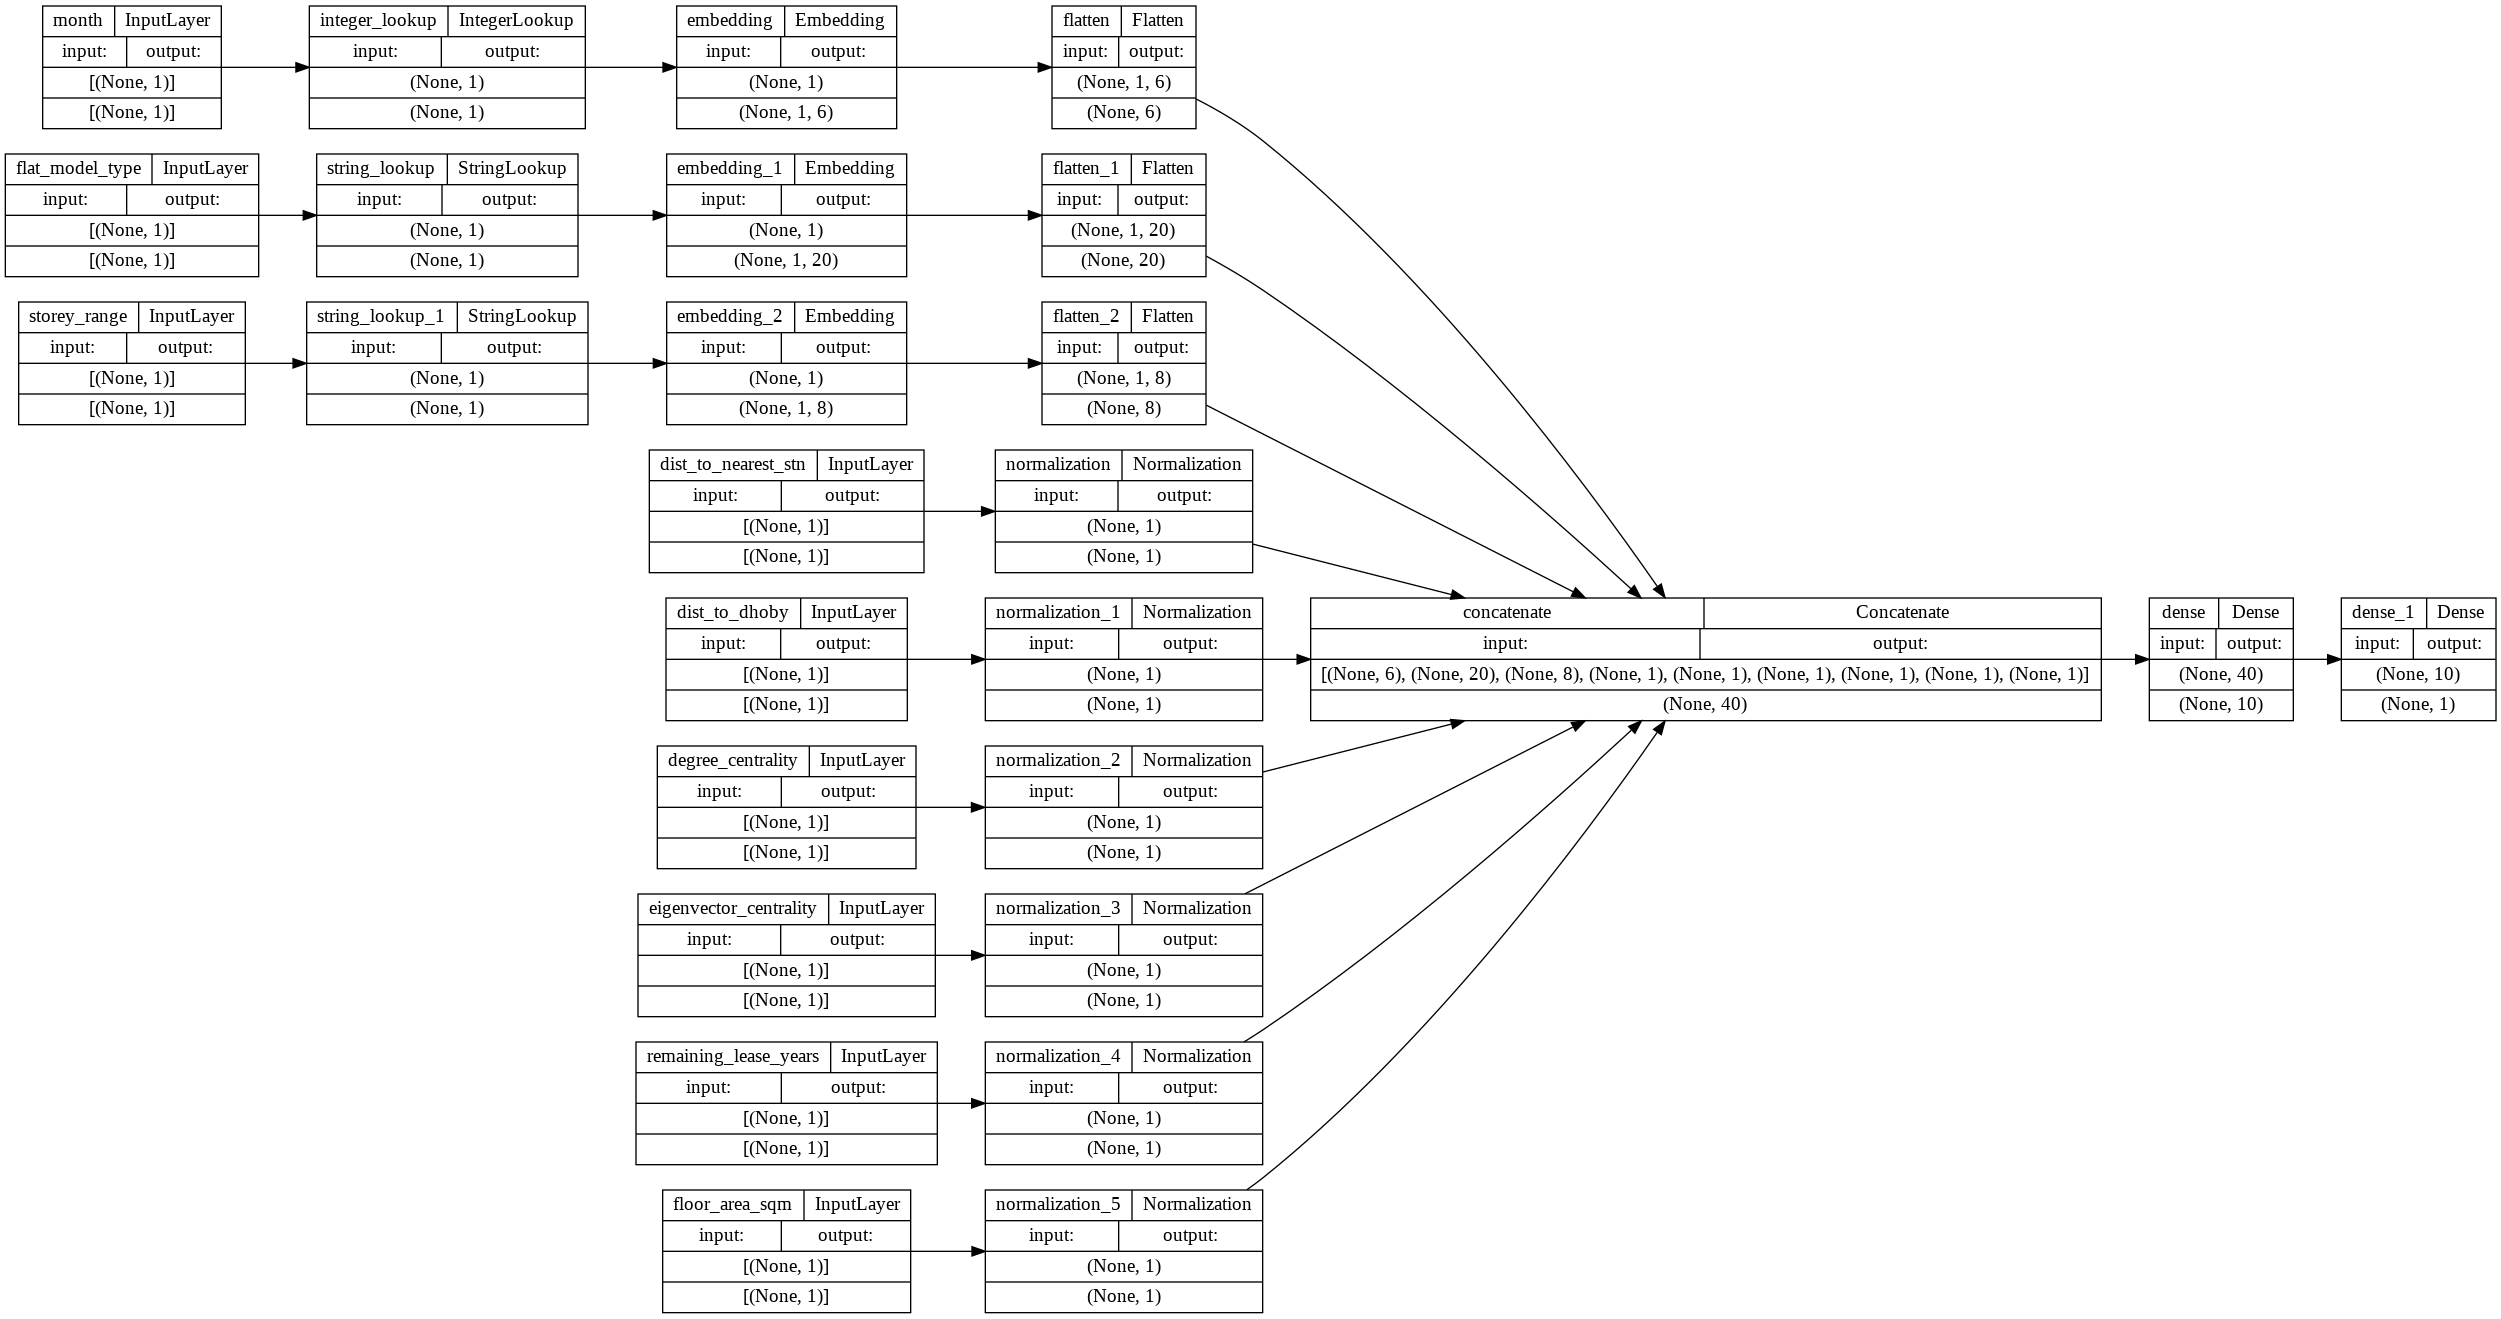

In [ ]:
x = layers.Dense(10, activation="linear")(all_features)
output = layers.Dense(1, activation="relu")(x)
model = keras.Model(all_inputs, output)
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR" )

# Q2c) Use KerasTuner to find best model and its set of hyperparameters

In [ ]:
!pip install keras-tuner
import kerastuner as kt

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  


In [ ]:
# build model using different hyperparameters
def build_model(hp):
  embedding_layers = []

# All Categorial Variables to be embedded
  categorial_variables = ["month", "flat_model_type", "storey_range"]

  # All Categorial Variables (encoded)
  categorial_variables_encoded = [month_encoded, flat_model_type_encoded, storey_range_encoded]

  # Generate an embedding for each categorial variable and store it
  for categorial_variable, categorial_variable_encoded in zip(categorial_variables, categorial_variables_encoded):

      # Output dimensions
      unique_categories  = train_dataframe[categorial_variable].nunique()
      embedding_size = np.floor((unique_categories)/hp.Int('divisor', min_value=1, max_value=2, step=1))
      embedding_size = int(embedding_size)

      # Input Dimensions
      input_dim  = unique_categories + 1
      
      # Embedding Layer
      embedding = Embedding(input_dim = input_dim, output_dim = embedding_size)(categorial_variable_encoded)

      # Add Flatten() layer
      embedding = Flatten()(embedding)
      embedding_layers.append(embedding)
  
  all_features = layers.concatenate(
    [
        embedding_layers[0],
        embedding_layers[1],
        embedding_layers[2],
        dist_to_nearest_stn_encoded,
        dist_to_dhoby_encoded,
        degree_centrality_encoded,
        eigenvector_centrality_encoded,
        remaining_lease_years_encoded,
        floor_area_sqm_encoded,
    ]
)
  x = layers.Dense(hp.Int('neurons', min_value=4, max_value=32, step=4), activation="linear")(all_features)
  output = layers.Dense(1, activation="relu")(x)
  model = tf.keras.Model(all_inputs, output)
  model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=2e-1, sampling='log')),loss='mse',metrics=['mse', r2])
  
  return model


In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10, overwrite = False)

In [ ]:
tuner.search(train_ds,validation_data=val_ds, epochs=50, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])

Trial 10 Complete [00h 02m 45s]
val_loss: 199521157120.0

Best val_loss So Far: 3713003776.0
Total elapsed time: 00h 22m 38s


In [ ]:
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

In [ ]:
print(f"""
The hyperparameter search is complete. The optimal number of neurons in the first densely-connected
layer is {best_hyperparameters.get('neurons')}, the optimal divisor is {best_hyperparameters.get('divisor')} and the optimal learning rate for the optimizer
is {best_hyperparameters.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of neurons in the first densely-connected
layer is 20, the optimal divisor is 2 and the optimal learning rate for the optimizer
is 0.12427649139617275.



# 2d) Use best model to train on non-test split and plot RMSE graph

In [ ]:
embedding_layers = []

# All Categorial Variables to be embedded
categorial_variables = ["month", "flat_model_type", "storey_range"]

# All Categorial Variables (encoded)
categorial_variables_encoded = [month_encoded, flat_model_type_encoded, storey_range_encoded]

# Generate an embedding for each categorial variable and store it
for categorial_variable, categorial_variable_encoded in zip(categorial_variables, categorial_variables_encoded):

    # Output dimensions
    unique_categories  = train_dataframe[categorial_variable].nunique()
    embedding_size = np.floor((unique_categories)/2)
    embedding_size = int(embedding_size)

    # Input Dimensions
    input_dim  = unique_categories + 1
    
    # Embedding Layer
    embedding = Embedding(input_dim = input_dim, output_dim = embedding_size)(categorial_variable_encoded)

    # Add Flatten() layer
    embedding = Flatten()(embedding)
    embedding_layers.append(embedding)

all_features = layers.concatenate(
  [
      embedding_layers[0],
      embedding_layers[1],
      embedding_layers[2],
      dist_to_nearest_stn_encoded,
      dist_to_dhoby_encoded,
      degree_centrality_encoded,
      eigenvector_centrality_encoded,
      remaining_lease_years_encoded,
      floor_area_sqm_encoded,
  ]
)

x = layers.Dense(20, activation="linear")(all_features)
output = layers.Dense(1, activation="linear")(x)
model = tf.keras.Model(all_inputs, output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.12427649139617275),loss='mse',metrics=[RootMeanSquaredError(), r2])

history = model.fit(train_ds, epochs=50,validation_data=val_ds)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


501/501 [==============================] - 4s 5ms/step - loss: 26358179840.0000 - root_mean_squared_error: 162352.0312 - r2: -0.1510 - val_loss: 6897173504.0000 - val_root_mean_squared_error: 83049.2266 - val_r2: 0.7078
Epoch 2/50
501/501 [==============================] - 2s 4ms/step - loss: 5558062080.0000 - root_mean_squared_error: 74552.4141 - r2: 0.7607 - val_loss: 5415359488.0000 - val_root_mean_squared_error: 73589.1250 - val_r2: 0.7683
Epoch 3/50
501/501 [==============================] - 3s 5ms/step - loss: 4613705216.0000 - root_mean_squared_error: 67924.2578 - r2: 0.8014 - val_loss: 4758019584.0000 - val_root_mean_squared_error: 68978.3984 - val_r2: 0.7972
Epoch 4/50
501/501 [==============================] - 3s 5ms/step - loss: 4131987968.0000 - root_mean_squared_error: 64280.5430 - r2: 0.8217 - val_loss: 4175411968.0000 - val_root_mean_squared_error: 64617.4297 - val_r2: 0.8216
Epoch 5/50
501/501 [==============================] - 4s 7ms/step - loss: 3912980992.0000 - root

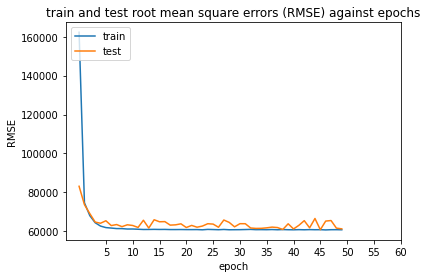

In [ ]:

plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('train and test root mean square errors (RMSE) against epochs')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.xticks([5, 10, 15, 20, 25, 30, 35,40, 45, 50, 55, 60])
plt.legend(['train', 'test'], loc='upper left')

# Q2e)

Using the model that we trained in 2d), we evaluate the model against the test dataset (beyond year 2020 data) and obtained a test R2 value of 0.6334 


In [ ]:
results = model.evaluate(test_ds)

360/360 [==============================] - 1s 3ms/step - loss: 9897933824.0000 - root_mean_squared_error: 99488.3594 - r2: 0.6334


In [ ]:
test_pred = model.predict(test_ds)

Now we append the prediction results to the original test dataframe

In [ ]:
test_dataframe['predictions'] = test_pred
test_dataframe.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price,predictions
87370,1,2021,170 ANG MO KIO AVENUE 4,Yio Chu Kang,1.276775,8.339960,0.016807,0.002459,"2 ROOM, Improved",64.083333,45.0,07 TO 09,225000.0,430415.37500
87371,1,2021,170 ANG MO KIO AVENUE 4,Yio Chu Kang,1.276775,8.339960,0.016807,0.002459,"2 ROOM, Improved",64.083333,45.0,01 TO 03,211000.0,630219.87500
87372,1,2021,216 ANG MO KIO AVENUE 1,Ang Mo Kio,0.994153,7.427003,0.016807,0.006243,"3 ROOM, New Generation",54.333333,73.0,04 TO 06,275888.0,385282.59375
87373,1,2021,223 ANG MO KIO AVENUE 1,Ang Mo Kio,1.349574,7.444314,0.016807,0.006243,"3 ROOM, New Generation",56.083333,67.0,07 TO 09,316800.0,628365.50000
87374,1,2021,223 ANG MO KIO AVENUE 1,Ang Mo Kio,1.349574,7.444314,0.016807,0.006243,"3 ROOM, New Generation",56.000000,67.0,10 TO 12,305000.0,284054.43750


I will create another column that shows the error between the actual resale price and predicted price, then sort the dataframe based on that column's values,

Lastly I will show the top 30 data

From the Table of the top 30 test samples with largest errors, we can see trends:
*   a relatively long 'remaining_lease_years'
*   several nearest stations at Outram Park and Bishan
*   The floor area is also > 100 sqm.
*   flat_model is 4-5 ROOM





In [ ]:
test_dataframe['test_error'] = abs(test_dataframe['resale_price'] - test_dataframe['predictions'])

In [ ]:
test_dataframe.sort_values(by=['test_error'], ascending=False).head(30)

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price,predictions,test_error
118242,3,2022,275A BISHAN STREET 24,Bishan,0.827889,6.370404,0.033613,0.015854,"5 ROOM, DBSS",88.500000,120.0,04 TO 06,1200000.0,115437.875000,1.084562e+06
127225,7,2022,92 DAWSON ROAD,Queenstown,0.584731,3.882019,0.016807,0.008342,"5 ROOM, Premium Apartment Loft",92.833333,122.0,37 TO 39,1418000.0,354078.937500,1.063921e+06
119399,5,2022,96A HENDERSON ROAD,Tiong Bahru,0.586629,2.932814,0.016807,0.047782,"5 ROOM, Improved",96.083333,113.0,40 TO 42,1400000.0,344516.906250,1.055483e+06
106097,8,2021,138A LORONG 1A TOA PAYOH,Braddell,0.461414,4.151360,0.016807,0.017995,"5 ROOM, DBSS",89.833333,114.0,40 TO 42,1238000.0,193553.000000,1.044447e+06
120247,4,2022,1G CANTONMENT ROAD,Outram Park,0.566594,2.661710,0.033613,0.121082,"4 ROOM, Type S1",87.833333,95.0,40 TO 42,1220000.0,209730.015625,1.010270e+06
127251,8,2022,3 HOLLAND CLOSE,Holland Village,0.334556,5.561626,0.016807,0.010276,"5 ROOM, Improved",75.333333,124.0,25 TO 27,1200000.0,189798.812500,1.010201e+06
120282,2,2022,1B CANTONMENT ROAD,Outram Park,0.352779,2.413099,0.033613,0.121082,"5 ROOM, Type S2",88.000000,106.0,31 TO 33,1235000.0,224952.218750,1.010048e+06
114244,12,2021,273B BISHAN STREET 24,Bishan,0.776182,6.297489,0.033613,0.015854,"5 ROOM, DBSS",88.750000,120.0,10 TO 12,1208000.0,203303.625000,1.004696e+06
97022,5,2021,275A BISHAN STREET 24,Bishan,0.827889,6.370404,0.033613,0.015854,"5 ROOM, DBSS",89.333333,120.0,25 TO 27,1128888.0,128151.156250,1.000737e+06
120295,7,2022,1E CANTONMENT ROAD,Outram Park,0.450314,2.546116,0.033613,0.121082,"5 ROOM, Type S2",87.583333,106.0,19 TO 21,1188000.0,191641.812500,9.963582e+05


# Q3a) Apply model on old and new test set

In [ ]:
df2 = pd.read_csv('/content/hdb_price_prediction_old.csv')


In [ ]:
# Split data
new_test_2021 = df[df['year'] == 2021]
new_test_2022 = df[df['year'] == 2022]
old_test_data = df2[df2['year'] > 2020]
# Generate tf.data.Dataset objects for each dataframe
new_test_2021 = dataframe_to_dataset(new_test_2021)
new_test_2022 = dataframe_to_dataset(new_test_2022)
old_test_data = dataframe_to_dataset(old_test_data)

# Batch the datasets
new_test_2021 = new_test_2021.batch(256)
new_test_2022 = new_test_2022.batch(256)
old_test_data = old_test_data.batch(256)


As seen below, we apply the model, the R2 values for the 3 differnt datasets are:

*   old test data R2 = 0.7572
*   New test 2021 R2 = -291784753152.0000
*   New test 2022 R2 = 0.4511



In [ ]:
model.evaluate(old_test_data)
model.evaluate(new_test_2021)
model.evaluate(new_test_2022)

133/133 [==============================] - 1s 3ms/step - loss: 15518688256.0000 - r2: 0.4511


[15518688256.0, 0.45105302333831787]

# Q3b)

Looking at the 3 R2 values above, we can see that the results are similar to the team for the old test data and new test dataset (2022). However, there is a much larger drop off in R2 value for new test dataset (2021). 

# 3c) Data distribution shifts

Since the largest drop off in R2 value was in the new test dataset for 2021, we are only going to examine the shift in features/labels between that dataset and the training dataset (2020 and before)

In [ ]:
new_test_2021 = df[df['year'] == 2021]

From the plots below, we can see how the distribution of the label variable 'resale price' SHIFTED across the same distribution of the respective feature variables.

In order to deal with data shifts, we can choose to take measures to retrain the model on new data periodically to ensure the model's performance is maintained at a high level 

[Text(0, 0.5, 'dist_to_dhoby'),
 Text(0.5, 0, 'resale price'),
 Text(0.5, 1.0, 'train data')]

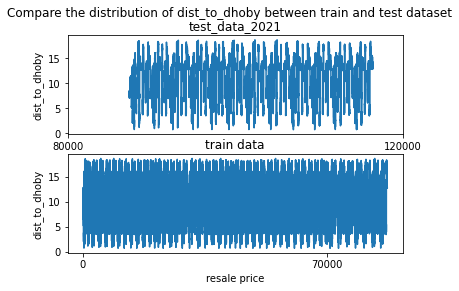

In [ ]:
fig, ax = plt.subplots(2)
fig.suptitle('Compare the distribution of dist_to_dhoby between train and test dataset')

ax[0].plot(new_test_2021['dist_to_dhoby'])
ax[0].set(xlabel='resale price', ylabel='dist_to_dhoby', title='test_data_2021',xticks=[80000, 120000])

ax[1].plot(train_dataframe['dist_to_dhoby'])
ax[1].set(xlabel='resale price', ylabel='dist_to_dhoby',title='train data', xticks=[0, 70000])


[Text(0, 0.5, 'dist_to_nearest_stn'),
 Text(0.5, 0, 'resale price'),
 Text(0.5, 1.0, 'train data')]

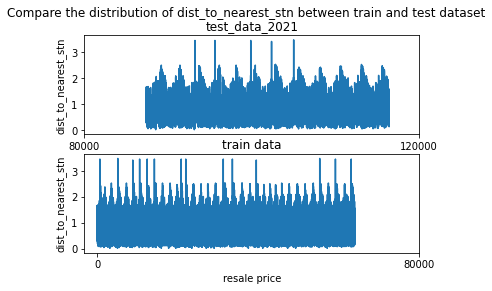

In [ ]:
fig, ax = plt.subplots(2)
fig.suptitle('Compare the distribution of dist_to_nearest_stn between train and test dataset')

ax[0].plot(new_test_2021['dist_to_nearest_stn'])
ax[0].set(xlabel='resale price', ylabel='dist_to_nearest_stn', title='test_data_2021', xticks=[80000, 120000])

ax[1].plot(train_dataframe['dist_to_nearest_stn'])
ax[1].set(xlabel='resale price', ylabel='dist_to_nearest_stn',title='train data',xticks=[0, 80000])

[Text(0, 0.5, 'dist_to_nearest_stn'),
 Text(0.5, 0, 'resale price'),
 Text(0.5, 1.0, 'train data')]

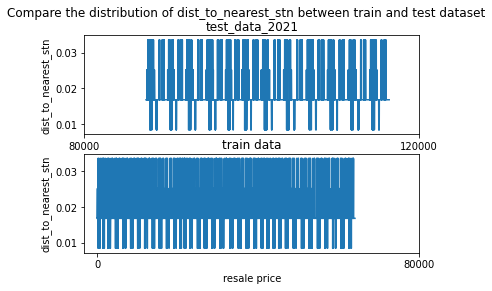

In [ ]:
fig, ax = plt.subplots(2)
fig.suptitle('Compare the distribution of dist_to_nearest_stn between train and test dataset')

ax[0].plot(new_test_2021['degree_centrality'])
ax[0].set(xlabel='resale price', ylabel='dist_to_nearest_stn', title='test_data_2021', xticks=[80000, 120000])

ax[1].plot(train_dataframe['degree_centrality'])
ax[1].set(xlabel='resale price', ylabel='dist_to_nearest_stn',title='train data',xticks=[0, 80000])

# Q3d) RFE

From the code below, we obtain the best subset to be [1, 1, 1, 1, 1, 1, 0, 1, 0]
This means the best features to include for training are [month, flat_model_type, storey_range, dist_to_nearest_stn, dist_to_dhoby,degree_centrality and remaining_lease_years]

In [ ]:
import time
start = time.time()

num_features = 9

vec = [1 for i in range(num_features)]
best_loss = 1e15
new_best_loss = 1e14
which_iter = ''
all_losses = [] # should be len 9,8,7,...


def train_model(feature_mask):
    """
    Given a boolean mask (feature_mask), select the features accordingly, train the model and return the validation loss.
    """
    
    feature_mask_string = ''.join([str(i) for i in feature_mask])
    
    # TODO: define the input layer here (your code from Q2)
    embedding_layers = []

    # All Categorial Variables to be embedded
    categorial_variables = ["month", "flat_model_type", "storey_range"]

    # All Categorial Variables (encoded)
    categorial_variables_encoded = [month_encoded, flat_model_type_encoded, storey_range_encoded]

    # Generate an embedding for each categorial variable and store it
    for categorial_variable, categorial_variable_encoded in zip(categorial_variables, categorial_variables_encoded):

        # Output dimensions
        unique_categories  = train_dataframe[categorial_variable].nunique()
        embedding_size = np.floor((unique_categories)/2)
        embedding_size = int(embedding_size)

        # Input Dimensions
        input_dim  = unique_categories + 1
        
        # Embedding Layer
        embedding = Embedding(input_dim = input_dim, output_dim = embedding_size)(categorial_variable_encoded)

        # Add Flatten() layer
        embedding = Flatten()(embedding)
        embedding_layers.append(embedding)

    all_features_input = [
      embedding_layers[0],
      embedding_layers[1],
      embedding_layers[2],
      dist_to_nearest_stn_encoded,
      dist_to_dhoby_encoded,
      degree_centrality_encoded,
      eigenvector_centrality_encoded,
      remaining_lease_years_encoded,
      floor_area_sqm_encoded]
    
    selected_inputs = []
    print('going through feature_mask', feature_mask)
    for i,j in zip(all_features_input, feature_mask):
        if j == 1:
            selected_inputs.append(i)
            print(i)
        else:
            print('Skipping', i)

    all_features = layers.concatenate(selected_inputs)
    
    # TODO: Complete the rest of the architecture + training code and retrieve the training history
    x = layers.Dense(20, activation="linear")(all_features)
    output = layers.Dense(1, activation="linear")(x)
    model = tf.keras.Model(all_inputs, output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.12427649139617275),loss='mse',metrics=[RootMeanSquaredError(), r2])
    history = model.fit(train_ds, epochs=50,validation_data=val_ds, verbose=0)

    val_loss_hx = history.history['val_loss'] # NOTE: You can use RMSE if you find it easier to interpret.
    val_loss_min = min(val_loss_hx)
    
    return val_loss_min

In [ ]:
while sum(vec) > 0 and best_loss > new_best_loss:
    
    print('vec', vec)

    best_loss = new_best_loss
    new_min_loss_flag = False
    
    losses_from_same_vec = []
    
    for ix, i in enumerate(vec):
        
        print('ix', ix, 'i', i)
        
        if i == 0:
            continue # if the feature is off, no need to do anything, go to next position
        else:
            temp_vec = vec[:]
            temp_vec[ix] = 0 # turn off the feature
            print('updated temp_vec', temp_vec)
            
            loss = train_model(temp_vec)
            losses_from_same_vec.append(loss)
            
            if loss < new_best_loss:
                new_best_loss = loss
                which_iter = 'len ' + str(sum(vec)) + ', ix ' + str(ix)
                print('new min loss:', which_iter)
                new_min_loss_flag = True
                min_loss_vec = temp_vec[:]

            tf.keras.backend.clear_session()
            print('session cleared!\n')
                
    
    all_losses.append(losses_from_same_vec)
    
    # After going through the vec once, update vec if new min loss    
    if new_min_loss_flag:
        vec = min_loss_vec
    
    # else case means no new min loss, the latter while loop condition will cause it to terminate 
    print(time.time() - start, 'seconds elapsed')
    print()

print(all_losses)

vec [1, 1, 1, 1, 1, 1, 1, 1, 1]
ix 0 i 1
updated temp_vec [0, 1, 1, 1, 1, 1, 1, 1, 1]
going through feature_mask [0, 1, 1, 1, 1, 1, 1, 1, 1]
Skipping KerasTensor(type_spec=TensorSpec(shape=(None, 78), dtype=tf.float32, name=None), name='flatten_3/Reshape:0', description="created by layer 'flatten_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 880), dtype=tf.float32, name=None), name='flatten_4/Reshape:0', description="created by layer 'flatten_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 144), dtype=tf.float32, name=None), name='flatten_5/Reshape:0', description="created by layer 'flatten_5'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='normalization/truediv:0', description="created by layer 'normalization'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='normalization_1/truediv:0', description="created by layer 'normalization_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float3

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


new min loss: len 9, ix 0
session cleared!

ix 1 i 1
updated temp_vec [1, 0, 1, 1, 1, 1, 1, 1, 1]
going through feature_mask [1, 0, 1, 1, 1, 1, 1, 1, 1]
KerasTensor(type_spec=TensorSpec(shape=(None, 78), dtype=tf.float32, name=None), name='flatten/Reshape:0', description="created by layer 'flatten'")
Skipping KerasTensor(type_spec=TensorSpec(shape=(None, 880), dtype=tf.float32, name=None), name='flatten_1/Reshape:0', description="created by layer 'flatten_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 144), dtype=tf.float32, name=None), name='flatten_2/Reshape:0', description="created by layer 'flatten_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='normalization/truediv:0', description="created by layer 'normalization'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='normalization_1/truediv:0', description="created by layer 'normalization_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=t

# Q3e)

According to the RFE done in 3d), removing the 'eigenvector_centrality_encoded' and 'floor_area_sqm' are the 2 features that we are removing to improve the model. Since this is different from the features that were eliminated in the old test data, we can conclude that concept drift has occurred.

# Conclusion


Optimization
Adding the embedding layers to learn from more richer representative of input data certainly helped the model to increase its performance. However, the recursive feature elimination had the most impact in optimizing the model. 

Better Alternatives
There are many machine learning algorithms that are capable of performing regression tasks, similar to our question. Some examples include Decision Tree Regression, Support Vector Machines (SVM), and Random Forests. I think whether they will outperform our current neural network model depends on their hyperparameter tuning and other settings.

Advantage of Neural network over machine learning models
Deep Learning really shines when it comes to complex problems such as image classification, natural language processing, and speech recognition.Deep learning is better when there is lack of understanding in domain specific problems.